In [1]:
# XGB regressor for Facebook (FB2A)
# high tech and internet 

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from stldecompose import decompose
import plotly as py
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [3]:
# read in the file
df1 = pd.read_csv("FB2A.csv")
# change to datetime format for further time series analysis
df1['Date'] = pd.to_datetime(df1['Date'])
# print head
df1.head()

,Mnemonic,Date,MaxPrice,MinPrice,StartPrice,EndPrice
0,FB2A,2019-01-23,130.95,126.91,129.36,127.41
1,FB2A,2019-01-24,128.76,125.48,127.12,126.97
2,FB2A,2019-01-25,130.48,128.83,129.37,130.48
3,FB2A,2018-04-12,136.31,132.99,134.71,133.54
4,FB2A,2018-04-13,134.32,132.76,133.06,133.41


In [4]:
# since the distributed file system does not preserve order of the data
# we have to sort the data by Date
df = df1.sort_values(by = 'Date')
# check to see whether we have successfully sorted or not
df.head()

,Mnemonic,Date,MaxPrice,MinPrice,StartPrice,EndPrice
288,FB2A,2018-01-02,149.6,146.0,146.8,149.6
289,FB2A,2018-01-03,152.6,150.8,151.2,152.6
290,FB2A,2018-01-04,154.0,152.6,153.6,152.6
492,FB2A,2018-01-05,154.4,153.0,153.2,154.2
493,FB2A,2018-01-08,158.0,155.4,155.8,157.0


In [5]:
# construct a dataframe for close price
df_close = df[['Date', 'EndPrice']].copy()
df_close = df_close.set_index('Date')
df_close.head()

,EndPrice
Date,
2018-01-02,149.6
2018-01-03,152.6
2018-01-04,152.6
2018-01-05,154.2
2018-01-08,157.0


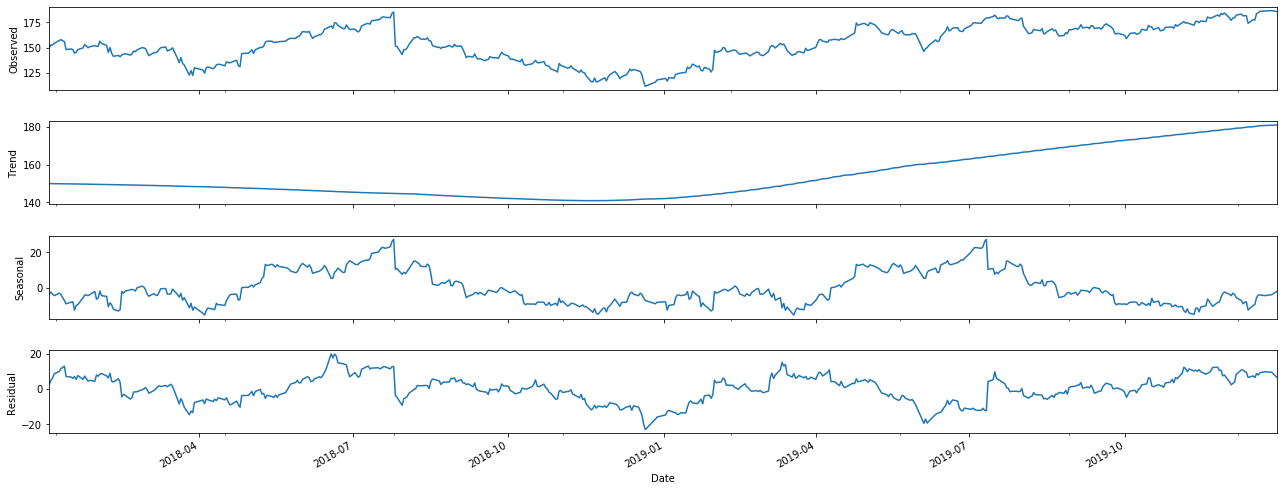

In [6]:
# plot decompose graph
decomp = decompose(df_close, period = 240)
fig = decomp.plot()
fig.set_size_inches(20, 8)


In [7]:
# moving averages
# simple moving averages and exponential moving averages
# exponential moving averages
df['EMA_9'] = df['EndPrice'].ewm(9).mean().shift()
# simple moving averages
df['SMA_5'] = df['EndPrice'].rolling(5).mean().shift()
df['SMA_10'] = df['EndPrice'].rolling(10).mean().shift()
df['SMA_15'] = df['EndPrice'].rolling(15).mean().shift()
df['SMA_20'] = df['EndPrice'].rolling(20).mean().shift()



In [8]:
# function for relative strength index
def relative_strength_index(df, n=14):
    close = df['EndPrice']
    delta = close.diff()
    delta = delta[1:]
    priceUp = delta.copy()
    priceDown = delta.copy()
    priceUp[priceUp < 0] = 0
    priceDown[priceDown > 0] = 0
    rollUp = priceUp.rolling(n).mean()
    rollDown = priceDown.abs().rolling(n).mean()
    rollchange = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rollchange))
    return rsi

# apply the function to the dataframe
df['RSI'] = relative_strength_index(df).fillna(0)

In [9]:
# Moving average convergence and divergence
EMA_12 = pd.Series(df['EndPrice'].ewm(span = 12, min_periods = 12).mean())
EMA_26 = pd.Series(df['EndPrice'].ewm(span = 26, min_periods = 26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span = 9, min_periods = 9).mean())


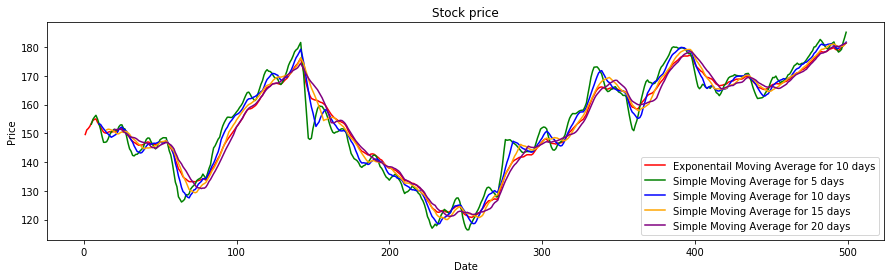

In [10]:
# plot moving averages to see whether they are good indicators of the close price
plt.figure(figsize=(15, 4));
plt.plot(df.EMA_9.values, color ='red', label ='Exponentail Moving Average for 10 days')
plt.plot(df.SMA_5.values, color ='green', label='Simple Moving Average for 5 days')
plt.plot(df.SMA_10.values, color ='blue', label = "Simple Moving Average for 10 days")
plt.plot(df.SMA_15.values, color ='orange', label ='Simple Moving Average for 15 days')
plt.plot(df.SMA_20.values, color ='purple', label ='Simple Moving Average for 20 days')

plt.title('Stock price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='best')

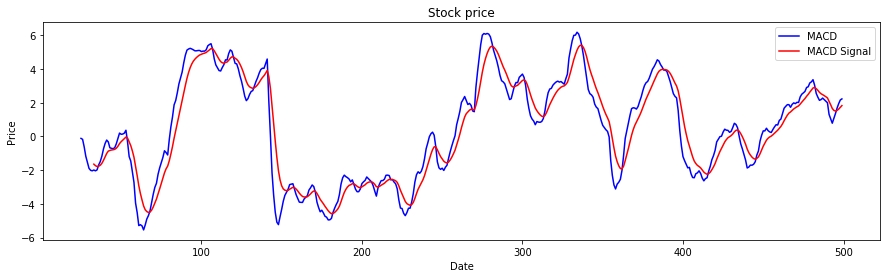

In [11]:
# plot MACD and MACD signals to see whether they are good indicators of the close price
plt.figure(figsize=(15, 4));
plt.plot(df.MACD.values, color ='blue', label = "MACD")
plt.plot(df.MACD_signal.values, color ='red', label ='MACD Signal')


plt.title('Stock price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='best')

In [12]:
# shift price label for time series analysis
df['EndPrice'] = df['EndPrice'].shift(-1)

In [13]:
# drop invalid samples
df = df.iloc[33:] 
df = df[:-1]      


In [14]:
# split test and valid set
test_size  = 0.10
valid_size = 0.10

test_split_idx  = int(df.shape[0] * (1-test_size))
valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))

# define training, test, and validate set
train_df  = df.loc[:valid_split_idx].copy()
valid_df  = df.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = df.loc[test_split_idx+1:].copy()

In [15]:
# drop cols that are not going to be included in the model
drop_cols = ['Date','StartPrice', 'MinPrice', 'MaxPrice', 'Mnemonic']

# drop cols for training, test, and validation sets
train_df = train_df.drop(drop_cols, 1)
valid_df = valid_df.drop(drop_cols, 1)
test_df  = test_df.drop(drop_cols, 1)

In [16]:
# define predictors and responses
y_train = train_df['EndPrice'].copy()
X_train = train_df.drop(['EndPrice'], 1)
y_valid = valid_df['EndPrice'].copy()
X_valid = valid_df.drop(['EndPrice'], 1)
y_test  = test_df['EndPrice'].copy()
X_test  = test_df.drop(['EndPrice'], 1)


In [17]:
# define parameters
parameters = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'max_depth': [8, 10, 15, 20],
    'gamma': [0.001, 0.005, 0.01, 0.02],
    'random_state': [55]
}

eval_set = [(X_train, y_train), (X_valid, y_valid)]
model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)
clf = GridSearchCV(model, parameters)

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

/Users/jingjie_ma/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



[17:43:32] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:43:32] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:43:32] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:43:33] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:43:33] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:43:33] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:43:34] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:43:34] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:43:34] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:43:34] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:43:34] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:43:34] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:43:35] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:43:35] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:43:35] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:43:36] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:43:36] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:43:36] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:43:36] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:43:36] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:43:37] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:43:37] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:43:37] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:43:37] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:43:39] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:43:39] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:43:39] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:43:41] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:43:41] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:43:41] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:43:42] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:43:42] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:43:42] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:43:43] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:43:43] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:43:43] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:43:44] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:43:44] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:43:44] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:43:44] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:43:44] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:43:45] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:43:45] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:43:45] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:43:46] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:43:46] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:43:47] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:43:47] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:43:48] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:43:48] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:43:48] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:43:49] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:43:49] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:43:49] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:43:51] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:43:51] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:43:51] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:43:52] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:43:52] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:43:52] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:43:53] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:43:53] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:43:53] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:43:53] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:43:54] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:43:54] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:43:54] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:43:54] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:43:54] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:43:55] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:43:55] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:43:55] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:43:56] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:43:56] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:43:56] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:43:57] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:43:57] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:43:57] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:43:58] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:43:58] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:43:58] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:44:00] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:44:00] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:44:00] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:44:01] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:44:02] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:44:02] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:44:02] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:44:02] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:44:02] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:44:04] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:44:04] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:44:04] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:44:05] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:44:05] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:44:05] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:44:05] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:44:05] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:44:06] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:44:06] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:44:06] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:44:07] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:44:07] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:44:08] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:44:08] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:44:09] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:44:09] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:44:09] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:44:10] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:44:10] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:44:10] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

In [18]:
# fit the model
model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.02, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=15,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=55, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

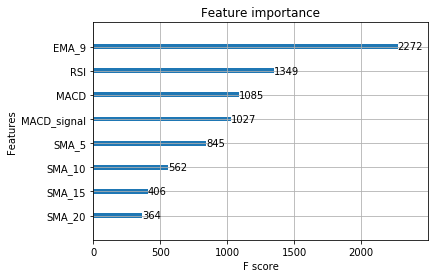

In [19]:
# plot importance plot of the model
plot_importance(model);

In [20]:
# predict on test sets
y_pred = model.predict(X_test)

In [21]:
y_preds = y_pred[:26]
y_true = np.array(y_test)[:26]

In [22]:
# print mse for the model
print(f'MSE = {mean_squared_error(y_true, y_preds)}')

MSE = 286.2327992445581
